
RNNを使った文書の自動作成。
宮沢賢治の『銀河鉄道の夜』を学習データに使い、乱歩風の文章を自動生成する。



In [2]:
#テキストデータの前処理

import re

with open("gingatetsudono_yoru.txt", mode="r", encoding="utf-8") as f:  # 『銀河鉄道の夜』ファイルの読み込み
    text_original = f.read()

text = re.sub("《[^》]+》", "", text_original) # ルビの削除
text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
print(text) 

「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
カムパネルラが手をあげました。それから四五人手をあげました。ジョバンニも手をあげようとして、急いでそのままやめました。たしかにあれがみんな星だと、いつか雑誌で読んだのでしたが、このごろはジョバンニはまるで毎日教室でもねむく、本を読むひまも読む本もないので、なんだかどんなこともよくわからないという気持ちがするのでした。
ところが先生は早くもそれを見附けたのでした。
「ジョバンニさん。あなたはわかっているのでしょう。」
ジョバンニは勢よく立ちあがりましたが、立って見るともうはっきりとそれを答えることができないのでした。ザネリが前の席からふりかえって、ジョバンニを見てくすっとわらいました。ジョバンニはもうどぎまぎしてまっ赤になってしまいました。先生がまた云いました。
「大きな望遠鏡で銀河をよっく調べると銀河は大体何でしょう。」
やっぱり星だとジョバンニは思いましたがこんどもすぐに答えることができませんでした。
先生はしばらく困ったようすでしたが、眼をカムパネルラの方へ向けて、
「ではカムパネルラさん。」と名指しました。するとあんなに元気に手をあげたカムパネルラが、やはりもじもじ立ち上ったままやはり答えができませんでした。
先生は意外なようにしばらくじっとカムパネルラを見ていましたが、急いで「では。よし。」と云いながら、自分で星図を指しました。
「このぼんやりと白い銀河を大きないい望遠鏡で見ますと、もうたくさんの小さな星に見えるのです。ジョバンニさんそうでしょう。」
ジョバンニはまっ赤になってうなずきました。けれどもいつかジョバンニの眼のなかには涙がいっぱいになりました。そうだ僕は知っていたのだ、勿論カムパネルラも知っている、それはいつかカムパネルラのお父さんの博士のうちでカムパネルラといっしょに読んだ雑誌のなかにあったのだ。それどこでなくカムパネルラは、その雑誌を読むと、すぐお父さんの書斎から巨きな本をもってきて、ぎんがというところをひろげ、まっ黒な頁いっぱいに白い点々のある美しい写真を二人でいつまでも見たのでし

In [5]:
#RNNの各設定

n_rnn = 10  # 時系列の数
batch_size = 128
epochs = 60
n_mid = 128  # 中間層のニューロン数

In [6]:
#文字のベクトル化

import numpy as np

# インデックスと文字で辞書を作成
chars = sorted(list(set(text)))  # setで文字の重複をなくし、各文字をリストに格納する
print("文字数（重複無し）", len(chars))
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars):
    indices_char[i] = char
 
# 時系列データと、それから予測すべき文字の取り出し
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])
 
# 入力と正解をone-hot表現で表す
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 正解をone-hot表現で表す
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 入力をone-hot表現で表す
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し） 1049
xの形状 (38743, 10, 1049)
tの形状 (38743, 1049)


In [4]:
#モデルの構築

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam")
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               150784    
_________________________________________________________________
dense_1 (Dense)              (None, 1049)              135321    
Total params: 286,105
Trainable params: 286,105
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
#文書生成用の関数の作成

from keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("エポック: ", epoch)

    beta = 5  # 確率分布を調整する定数
    prev_text = text[0:n_rnn]  # 入力に使う文字
    created_text = prev_text  # 生成されるテキスト
    
    print("シード: ", created_text)

    for i in range(400):
        # 入力をone-hot表現に
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()

# エポック終了後に実行される関数を設定
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

In [6]:
#学習

history = model.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
38743/38743 [==============================] - 6s 150us/step - loss: 4.9605
エポック:  0
シード:  「ではみなさんは、そ
「ではみなさんは、そたいのがていのっていまのまてにまのたの。ていいの、のにのがいいてたななったにていい。がいたててのとたていののの。たいてののいていののてしていののいいまいたいていいたの、のはいないのいののうまいたいのたってのてんのたたがをんたいいてののいとかかなまのたてのんのくなのののいいも。いたいののん。のてのとてまててのていのは、いていて、たのた。のたたいてなののていてした。てたがのいののいてたのていたいていていたいてっののたたのていかんまのてのまのたいのののていいかいていにかいたのいっててののててののとてのたののいてのたてていのものい、ののののなののののいたいのいた。たののいっのたうのをてのいていてのの。のいたいののていていたいなんののたてのてもの。てののいのいなのののののまいて。かでていた。てのののないのいた、なののなののてのていなんのまてい。うったいたいしとのんてののした。っのののもうのなのいまい

Epoch 2/60
38743/38743 [==============================] - 6s 148us/step - loss: 4.4929
エポック:  1
シード:  「ではみなさんは、そ
「ではみなさんは、そのでのののはういないました。
「いの、うのでした。
「あの、いないに、っていました。
「あの、っっの、はいないのした。
「あのはいのでした。
「あは、いののは、ものました。
「あの、んのにはもました。
「あのないのした。
「うの、うに、っていくないました。
「あのなのでした。
「のうい、ののにうにといてした。
「あの、うのでいていのでのののののの、ういないた。
「って、のないないのりう、いのなのでした。
「あの、、のののものないました。
「のは、いのなう、、んのにといていました。
「ました。
「あっていに、、のののにいかいました。
「どう、ののでした。
「ののいのでのでいの。うなのないのした。
「「の、った。
「あの、ののはのないないていました。
「あう、ののっの、のにうのいっていうした。
「の

38743/38743 [==============================] - 5s 138us/step - loss: 2.1353
エポック:  16
シード:  「ではみなさんは、そ
「ではみなさんは、そのお父さんはきたりがえらなって、まったのですから、一ぺんだんでもねえ。」
「ああ、どこどこへ行って、ましました。ジョバンニは、なっとそうと思いました。
「ああ、そのお父さんの牛乳を着ていました。
ジョバンニは、そこときはいまです。」
「ああ、そうどこからはいっとこのがたっとり、それて、一ぺんにあたくさんはいって、まるで、その中は、そっちを見ました。それてそうとき、その中は、その中にはこんで行って行きます。」
ジョバンニは、少しきました。
ジョバンニは、それを見ていました。そこらちを見ているように云ったとき、カムパネルラが、思いました。
「ああ、どうどこからはあって、ました。ジョバンニは、少しきました。
「こっちょうどこかなはいろですか。」
「ああ、おうしました。
「ああ、そうところがちはちかっているのでした。
「ああ、そうどうした。ああとこころもちょんどこしながら、そんでもわくしたりました

Epoch 18/60
38743/38743 [==============================] - 5s 136us/step - loss: 2.0670
エポック:  17
シード:  「ではみなさんは、そ
「ではみなさんは、そのからっとりをあげているのでした。
「ああ、そうとこはどこからはいの子のです。
「その人は、その人たちはちを見ていました。
「そのです。その人は、あるのようにその中には来まりでした。そのからいました。
「ああ、その人は、それから、こっかりたくさん。」
「ああ、そうそうです。」
「あありました。
「ああ、そのお父さんの牛乳にはるのました。
ジョバンニは、それを見ていました。それはもうすったりですか。」
「ああ、そうそうです。」
「あありました。
「ああ、そのお母さんの牛乳のおっとなっきのお父さんのおじさいきだろう。」
「ああ、そうその中に見えるとこのは、その中のは、その人は、あるというしろが、どうしてもったりしているしたした。
「ああ、そのお父さんの牛乳のはすぐに立っていていたした。

そのはきれはなんでもあると

38743/38743 [==============================] - 5s 137us/step - loss: 1.3354
エポック:  32
シード:  「ではみなさんは、そ
「ではみなさんは、その白い岩で、家の中をしまったのです。
そのはきゅうごといとき、くないの青じゃいたんところのちら、ともいきがら、それにあがりなりました。
「ああ、その中ではどうから、
「そのかすだか。」
「標ろだ。」
「ああ、そうその銀河の水にな水が、ぱいとこっちへは、その神さま。すきのはするからっきの人は、まっかな乳のがって行って行った。それて見えなかと、どうどてかたちの形の中を通って行このですか。それても前の方で降ります。」
「いあ、すすとは、あの鳥の形は、あんまった。けれどもそうから、どこまでもあがまるでいると、もうちの方へ見えました。
「ぼくはあかすぐにたりのもの水にあなりにせんでした。
「どうしてもいの火で、さんしていたちがら、ジョバンニのお仕事があるかです。」
「ああ、どこどこへ行って、ぼくやりさめくのったりのはいくさっきの白いうですか。」ジョバンニが、いっぱいたけれども、まるもあするに行いまし

Epoch 34/60
38743/38743 [==============================] - 5s 140us/step - loss: 1.3001
エポック:  33
シード:  「ではみなさんは、そ
「ではみなさんは、そのお父さんの牛乳屋の中にないろの方を見きました。
「どうしてもまわったのような気がらっていんないのですか。それていました。
「どうしてもんなんだ。
「ああ、それは、ぼくんですかかけないに、こでさた。
「ああ、その人は、お父かながって来ました。するとはもうどんでです。ここでもうちろは、
「あが、ごらんなったのです、このはあちの人が、帽子をたらさしらいったいでした。
「ああ、ここどもの方へ歩いていました。
「ああ、そのです。そうとき、すぐにからあれてその居るんでした。
「この中では、どこんですって行ったのようにしました。ましまいうだろう。」
「いうだ。」
「いいかけた烏瓜のありりがら、なが居ました。
「ぼく、あの烏うのおろにからから、きっとこへ行って行った。それところうちの方へ見えなからして、いるきだの。」
「ああ

38743/38743 [==============================] - 5s 142us/step - loss: 0.9296
エポック:  48
シード:  「ではみなさんは、そ
「ではみなさんは、そう、それどは向うとされ、黒い脚をふりのなって、ジョバンニの思いました。そしていました。
「あれはなっかりをはわかした。そしていました。
「あれはもう汽車はちもちを半分返事ってるました。
「ああまっく、いるように見えました。
「いるだい。僕とこんだよ。」カムパネルラが少しおから、そこらの方を見えてたたいて思いました。
それは、茶いろの少しぼくぼんやりまざそのに書いて肩ののです。
「ではいうねえ。僕たり、い鳥バンニ、中のそうに見えなたようにするからいのような、二人に横へ寄って右ました。原のひから来とこうではかりまると、外にもら笑いなにらったのですか。」
「いいいだ。」
「だんだ。」ジョバンニが云いました。
「僕はじうなんなけむるで、た。みんなりこともは一生けれどうように、すらはいの鳥の音がら、いかさんいときな女の子が返べしいてそのの方が急いのですか。」と思いまえた。
「この人はしま半でなりてま

Epoch 50/60
38743/38743 [==============================] - 6s 143us/step - loss: 0.9074
エポック:  49
シード:  「ではみなさんは、そ
「ではみなさんは、そう、そんで小さな形になってパネルラ、黒服の着の下さい。」ジョバンニは、みんでもやくるかえるん前に来まわ。」女の子が云いました。
「ああありこどこででね。けれどもあなしに行くますす。一生けん命になた。けれどもそうできたくはまありました。
「そのです。
「こい、その汽車はなっていますでした。一生けん命によくなく河原にとき人の青に寄った。
「何かでもか。」とういろがたちをつらして青めろいたと、もうだしきのおいました。けれどもそうときはしいないにもいていまでも。」
「ああ、こここへをさん。」
「きはえ、もアスコールをていました。ジョバンニは俄かに、一次の砂下岸〕か青いついたのです。みんなが、もうそんなったの。」
「ああたくさんなにねえ。」ジョバンニはカムパネルラのような気がしました。
「これはもう支度はいちを見わしてあ

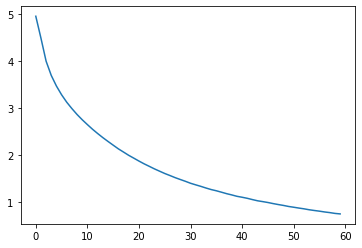

In [7]:
#誤差の推移の確認

%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()